<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-month-a-datetime" data-toc-modified-id="Conversión-de-la-columna-month-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna month a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARMA" data-toc-modified-id="Modelo-ARMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARMA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")


In [2]:
#!pip install statsmodels

# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [3]:
df = pd.read_csv("data/data2.csv")
df.head()

,month,mean_temp
0,1982-01,25.9
1,1982-02,27.1
2,1982-03,27.2
3,1982-04,27.0
4,1982-05,28.0


## Conversión de la columna month a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.isnull().sum()

month        0
mean_temp    0
dtype: int64

In [5]:
df.dtypes

month         object
mean_temp    float64
dtype: object

In [7]:
df.index = pd.to_datetime(df["month"])
df.head()

,month,mean_temp
month,,
1982-01-01,1982-01,25.9
1982-02-01,1982-02,27.1
1982-03-01,1982-03,27.2
1982-04-01,1982-04,27.0
1982-05-01,1982-05,28.0


In [8]:
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq=None)

In [9]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq='MS')

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [10]:
df.head()

,month,mean_temp
month,,
1982-01-01,1982-01,25.9
1982-02-01,1982-02,27.1
1982-03-01,1982-03,27.2
1982-04-01,1982-04,27.0
1982-05-01,1982-05,28.0


In [12]:
df.drop("month",  inplace = True, axis = 1)

In [13]:
df.head()

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendendia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [14]:
df2 = df.copy()
df2.head()

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


In [15]:
df2["año"] = df2.index.year
df2["mes"] = df2.index.month


In [16]:
df2.head()

,mean_temp,año,mes
month,,,
1982-01-01,25.9,1982,1
1982-02-01,27.1,1982,2
1982-03-01,27.2,1982,3
1982-04-01,27.0,1982,4
1982-05-01,28.0,1982,5


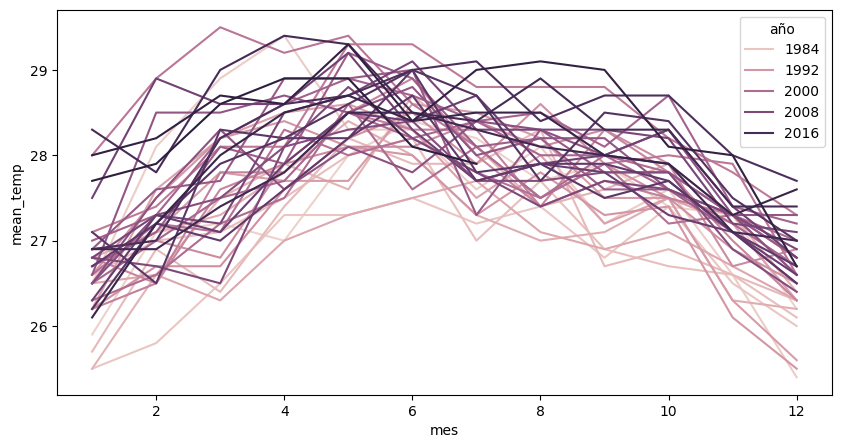

In [18]:
sns.lineplot(x = "mes", y = "mean_temp", hue = "año", data = df2);

## Estacionaridad

Existe una tendencia cuando hay un aumento o una disminución a largo plazo en los datos. No tiene por qué ser lineal. A veces se dice que una tendencia "cambia de dirección" cuando puede pasar de una tendencia creciente a una tendencia decreciente. Se puede decir que una serie es estacionaria cuando **su media y su varianza no están en función del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayoría de los métodos estadísticos para realizar análisis y predicciones se basan en la suposición de que las propiedades estadísticas de la serie (media, varianza, correlación, etc.) son constantes en el tiempo.

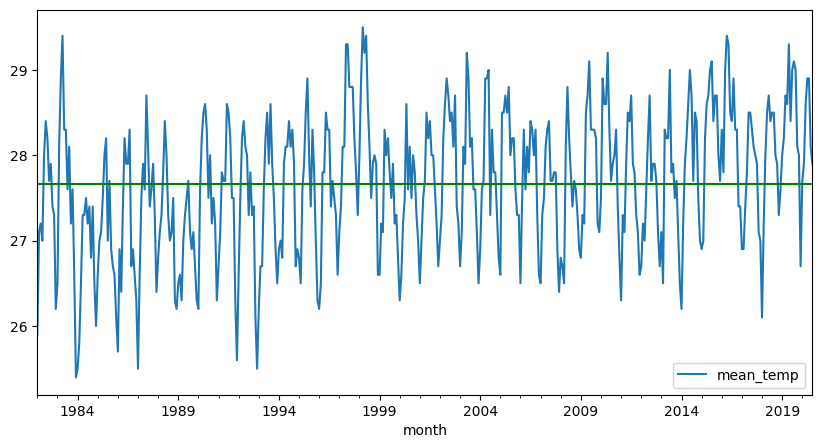

In [20]:
df.plot()
plt.axhline(df.mean_temp.mean(), c = "g")

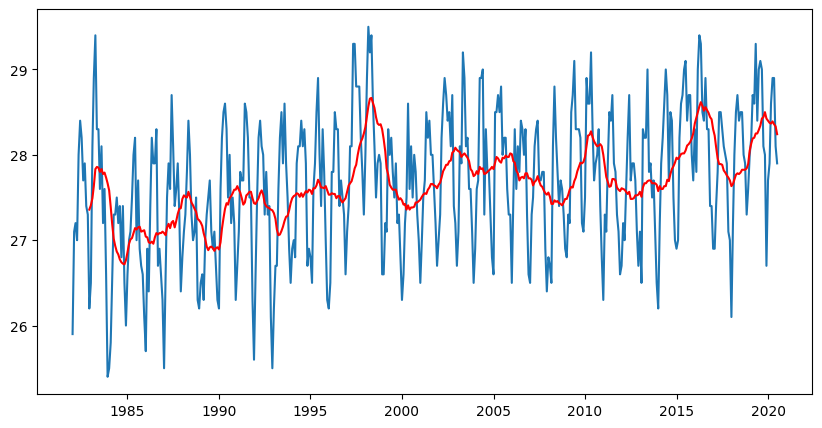

In [25]:
plt.plot(df["mean_temp"])
plt.plot(df.rolling(window= 12).mean(), c = "r")


Al plotear la media junto con los puntos de datos originales, podemos ver que son  algo constantes en el tiempo, no vemos ninguna tendencia de incremento o disminución. Sin embargo, parecen seguir un comportamiento. cíclico. Pero esto nos puede convencer poco, también podemos hacer el test de ADFuller

In [26]:
df.head()

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


In [27]:
res = adfuller(df["mean_temp"])
res

(-4.3683613705968956,
 0.0003375321830770895,
 18,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 572.4644501818075)

In [30]:
print("AD Fuller Stats", res[0])
print("p-value", res[1])
print("Critical values")

for k, v in res[4].items():
    print(k, round(v, 2))

AD Fuller Stats -4.3683613705968956
p-value 0.0003375321830770895
Critical values
1% -3.45
5% -2.87
10% -2.57


¿Cuáles son las conclusiones de esta prueba?

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS

- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS

En nuestro caso, nuestros datos son estacionarios! 

## Comparativa estacionalidad vs estacionaridad

# Autocorrelación

La autocorrelación es un tipo de dependencia temporal. En concreto, la autocorrelación se produce cuando una serie temporal está relacionada linealmente con una versión retardada de la misma. 

**Se trata de una medida de la correlación de los datos de la serie temporal en un momento dado con los valores pasados, lo que tiene enormes implicaciones en muchos sectores. Por ejemplo, si nuestros datos de ventas de caramelos tienen una fuerte autocorrelación, podemos suponer que un número elevado de ventas hoy sugiere una fuerte probabilidad de que también sea elevado mañana**


Quizás el aspecto más convincente del análisis de autocorrelación es cómo puede ayudarnos a descubrir patrones ocultos en nuestros datos y a seleccionar los métodos de previsión correctos. En concreto, podemos utilizarlo para ayudar a identificar la estacionalidad y la tendencia en nuestros datos de series temporales. Además, el análisis conjunto de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) es necesario para seleccionar el modelo ARIMA adecuado para la predicción de series temporales.

- `Auto-correlación`: la correlación entre dos momentos/instantes de tiempo.


- `Auto-correlación parcial`: es una medida de la correlación entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), después de ajustarse para la presencia de los demás términos de desfase más corto (yt-1, yt-2, ..., yt–k–1).

![auto](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-20/imagenes/autocorrelation-anatomy-python.jpg?raw=true)

In [34]:
for i in range(49):
    print(f"{i} mes Lag, {df['mean_temp'].autocorr(lag= i)}")

0 mes Lag, 1.0
1 mes Lag, 0.7230976534612946
2 mes Lag, 0.4564015612394833
3 mes Lag, 0.16726948619310658
4 mes Lag, -0.056569870839973474
5 mes Lag, -0.20708869349842243
6 mes Lag, -0.23506213283039426
7 mes Lag, -0.18591221141271785
8 mes Lag, -0.05524756614084002
9 mes Lag, 0.11148078934744748
10 mes Lag, 0.34044115096052513
11 mes Lag, 0.5448761604069142
12 mes Lag, 0.6542048276244479
13 mes Lag, 0.5235635613127931
14 mes Lag, 0.2920808865550884
15 mes Lag, 0.03943547096521894
16 mes Lag, -0.1613563570935575
17 mes Lag, -0.3231699799160958
18 mes Lag, -0.35956506377112274
19 mes Lag, -0.3378846358267866
20 mes Lag, -0.1869893908717057
21 mes Lag, 0.013005203250428525
22 mes Lag, 0.2940794142108538
23 mes Lag, 0.5065770773564024
24 mes Lag, 0.5923959601860325
25 mes Lag, 0.4923219978094839
26 mes Lag, 0.2442076982078187
27 mes Lag, -0.010047525989839014
28 mes Lag, -0.19635578666086845
29 mes Lag, -0.3240662726073282
30 mes Lag, -0.3691759897946966
31 mes Lag, -0.3234137247413465
32

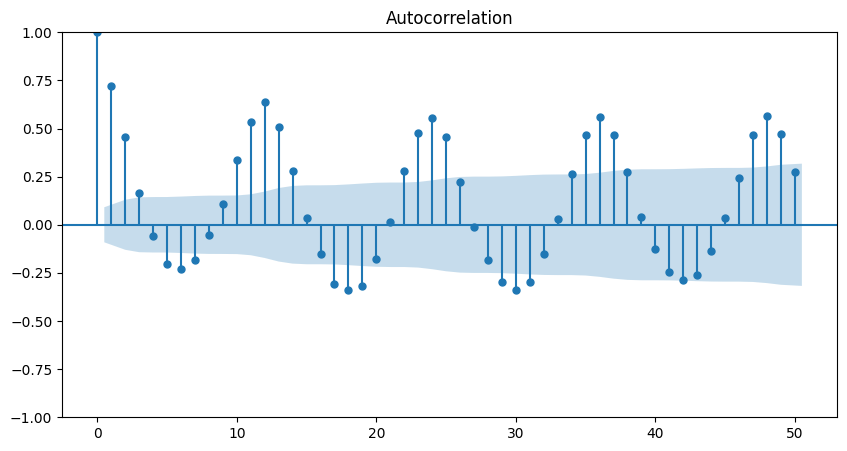

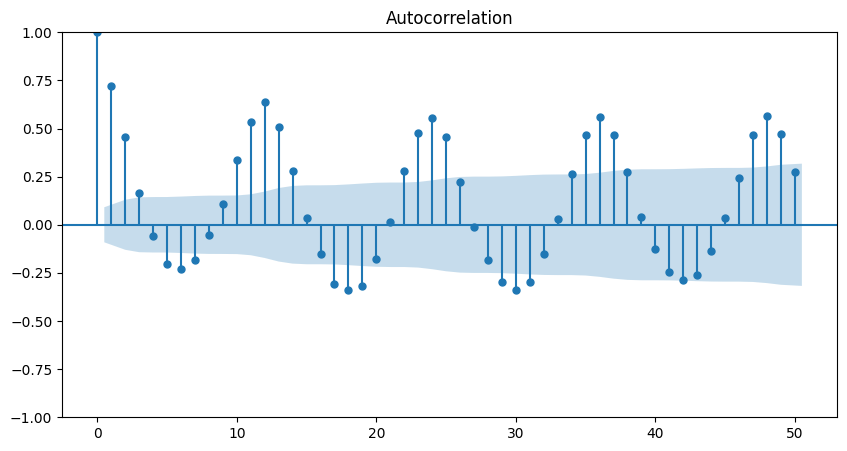

In [36]:
plot_acf(df, lags = 50)

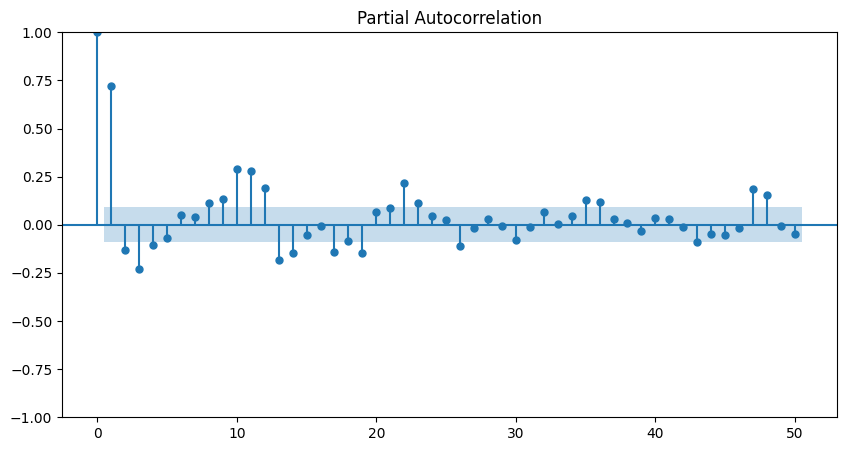

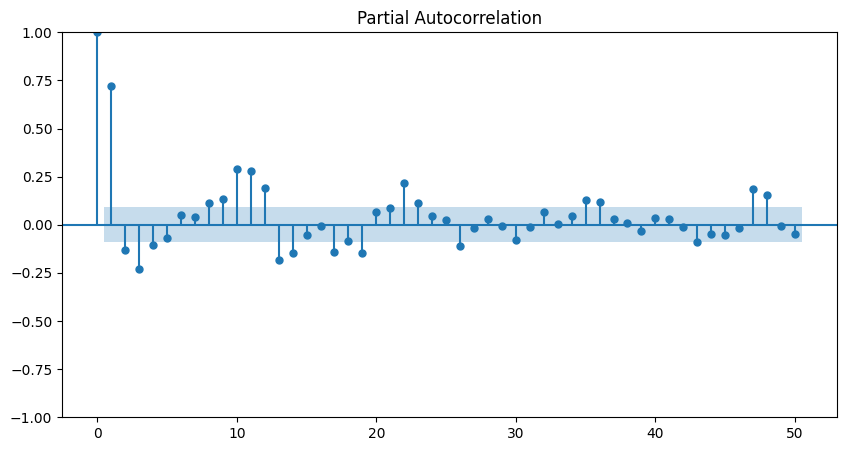

In [37]:
plot_pacf(df, lags = 50)

Veamoslo visualmente, los gráficos generados a partir de estas funciones se denominan correlogramas, los cuales contienen bandas con un intervalo de confianza del 95%.

In [38]:
df.head(2)

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1


In [39]:
y_test = df["mean_temp"][-30:]
y_train = df["mean_temp"][:-30]

In [40]:
df.shape

(463, 1)

In [44]:
ps = range(5)
qs = range(7)

parametros = list(product(ps, qs))
print(parametros)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)]


In [49]:
rmse = []
orden = []

for p, q in parametros:
    modelo = ARIMA(y_train, order = (p, 0, q)).fit()
    pred = modelo.predict(start = len(y_train), end = len(df) -1)
    error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
    rmse.append(error)
    orden.append((p, q))

In [53]:
len(rmse)

35

In [54]:
len(orden)

35

In [58]:
results = pd.DataFrame({"RMSE": rmse, "order": orden})
results.sort_values(by ="RMSE", ascending = True).head()

,RMSE,order
23,0.715676,"(3, 2)"
31,0.754952,"(4, 3)"
18,0.766011,"(2, 4)"
25,0.769156,"(3, 4)"
17,0.771354,"(2, 3)"


# Modelo ARMA

El modelo ARMA, del inglés, *AutoRegressive Moving Average* se divide en dos partes:

- `Autorregresivo(AR)`: la variable dependiente depende de sí misma en un período de tiempo t. **Será la `p` y lo sacaremos de la gráfica de autocorrelación**. En otras palabras, el modelo autorregresivo se basa en la idea de que la observación actual puede explicarse con valores pasados. Estos modelos se denotan como AR(p) siendo p el número de muestras que explican la muestra actual. Es decir, un AR(1) quiere decir que sólo la muestra anterior y el ruido contribuye a la salida. Un AR(2) las dos anteriores y el ruido, etc. 


- `Media móvil(MA)`: los retrocesos son representados por procesos aleatorios. **Será la `q` y lo sacaremos de la gráfica de autocorrelación parcial**. Es decir, consiste en realizar una aproximación a la serie utilizando únicamente ruido blanco. Por ejemplo, los órdenes de media móvil de 2 especifican que las desviaciones respecto al valor medio de la serie de cada uno de los dos últimos períodos de tiempo se tienen en cuenta al predecir los valores actuales de la serie.


Juntando ambos términos obtenemos los modelos ARMA (p,q), los cuáles determinan la serie en función su pasado hasta el retardo p, del ruido actual y el pasado del ruido hasta el retardo q. Hemos comentado anteriormente que lo que no consiguiésemos modelar de forma estacionaria sería ruido blanco. 

> la d es el número de diferencias no estacionales. En este caso SIEMPRE SERÁ 0. 


Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [59]:
modelo = ARIMA(y_train, order = (4,0, 3) ).fit()
pred = modelo.predict(start = len(y_train), end = len(df) -1)


In [61]:
y_test

month
2018-02-01    27.2
2018-03-01    28.0
2018-04-01    28.5
2018-05-01    28.7
2018-06-01    28.4
2018-07-01    28.5
2018-08-01    28.5
2018-09-01    28.0
2018-10-01    27.9
2018-11-01    27.3
2018-12-01    27.6
2019-01-01    28.0
2019-02-01    28.2
2019-03-01    28.7
2019-04-01    28.6
2019-05-01    29.3
2019-06-01    28.4
2019-07-01    29.0
2019-08-01    29.1
2019-09-01    29.0
2019-10-01    28.1
2019-11-01    28.0
2019-12-01    26.7
2020-01-01    27.7
2020-02-01    27.9
2020-03-01    28.6
2020-04-01    28.9
2020-05-01    28.9
2020-06-01    28.1
2020-07-01    27.9
Freq: MS, Name: mean_temp, dtype: float64

In [64]:
df_pred = pd.DataFrame(pred)
df_pred["real"] = y_test

In [66]:
df_pred.head()

,predicted_mean,real
2018-02-01,26.682240,27.2
2018-03-01,27.201760,28.0
2018-04-01,27.762479,28.5
2018-05-01,28.115644,28.7
2018-06-01,28.355472,28.4


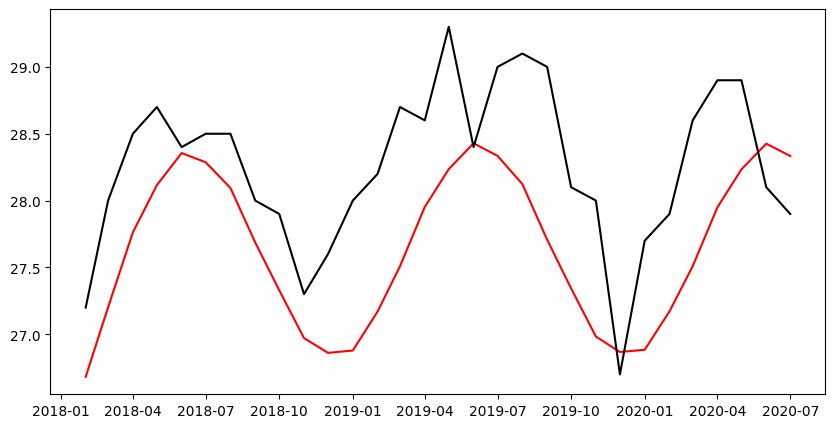

In [68]:
plt.plot(df_pred["predicted_mean"], c = "r")
plt.plot(df_pred["real"], c = "black");

In [70]:
pred_año = pd.DataFrame(modelo.predict(start = len(df), end = len(df) + 12))
pred_año

,predicted_mean
2020-08-01,28.123015
2020-09-01,27.709831
2020-10-01,27.345067
2020-11-01,26.986449
2020-12-01,26.869426
2021-01-01,26.886210
2021-02-01,27.170787
2021-03-01,27.508742
2021-04-01,27.947227
2021-05-01,28.231600


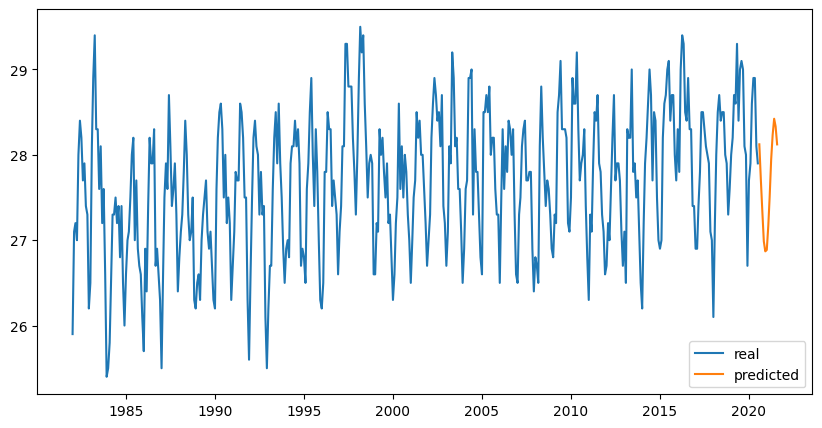

In [71]:
# ploteamos los resultados

plt.plot(df)
plt.plot(pred_año)
plt.legend(["real", "predicted"]);

**Vamos a hacer predicciones más allá de los datos que tenemos, en concreto intentaremos predecir los siguientes doce meses**